##### 影片轉透明背景 gif 動畫
這篇教學延伸「將指定的顏色變透明」和「處理 gif 動畫」教學，透過 OpenCV 讀取影片，將特定顏色的背景去除後 ( 去背 )，輸出成背景透明的 gif 動畫。

因為程式中的 OpenCV 會需要使用鏡頭或 GPU，所以請使用本機環境或使用 Anaconda Jupyter 進行實作，\
並安裝 OpenCV 函式庫 ( 參考：[OpenCV 函式庫](https://steam.oxxostudio.tw/category/python/ai/opencv.html) )。

##### 如何轉存背景透明的 gif 動畫 
在「處理 gif 動畫」文章裡有介紹 PIL 的 save 方法，這個方法能夠將多張圖片合併儲存為 gif 動畫，但如果是背景透明的動畫，\
則常常會發生存檔後背景還是不透明的狀況，以下圖為例，原本在 png 都是背景透明的圖片，透過 save 組合成 gif 動畫後，\
有些影格看起來雖然去背，但去背的區域卻被填滿了某些特定顏色。

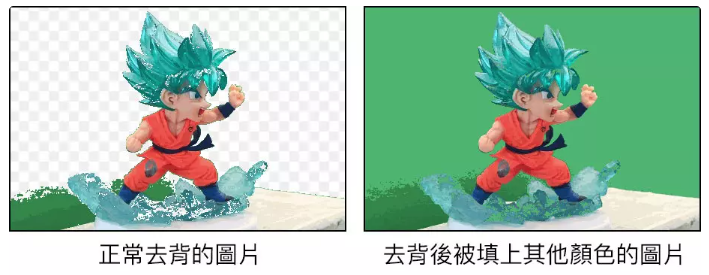

為什麼會這樣呢？因為 png 和 gif 擁有的色彩數量不同，gif 屬於索引色模式，最多只有 256 個顏色，而透明色也包含在這 256 個顏色裡，\
當讀取 png 後，雖然透過了 convert 的方式轉換為 RGBA，但每張圖片的透明色，卻不一定放在顏色空間中的同樣位置，當再次使用 save 方法時，\
會以「第一個影格」透明色的位置為基準，所以就導致有些影格透明，有些影格不透明的狀況。

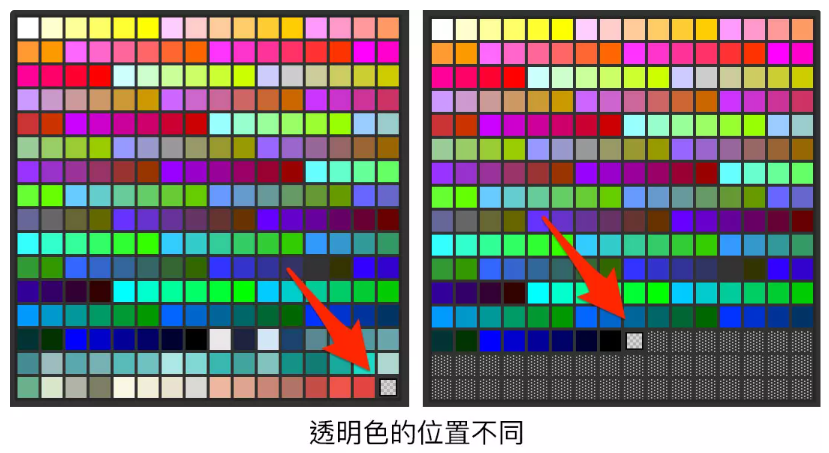

為了避免這種情況發生，可以先將要轉換的影格輸出為 gif，然後再次讀取這些 gif 並轉換為 RGBA，轉換後會產生透明色固定在最後方的索引色版，\
最後轉存時設定 disposal=2，就能產生背景透明的 gif 動畫 ( disposal 若設為 0，表示會與第一個重疊，因此背景透明時會發生重疊殘影的狀況 )。

In [ ]:
n = 0
for i in source:                  # source 為要轉存的所有圖片陣列 ( opencv 格式，色彩為 RGBA )
    img = Image.fromarray(i)      # 轉換成 PIL 格式
    img.save(f'temp/gif{n}.gif')  # 儲存為 gif
    n = n + 1                     # 改變儲存的檔名編號

output = []                       # 建立空串列
for i in range(n):
    img = Image.open(f'temp/gif{i}.gif')  # 依序開啟每張 gif
    img = img.convert("RGBA")             # 轉換為 RGBA
    output.append(img)                    # 記錄每張圖片內容

# 轉存為 gif 動畫，設定 disposal=2
output[0].save("oxxostudio.gif", save_all=True, append_images=output[1:], duration=100, loop=0, disposal=2)

##### 影片轉透明背景 gif 動畫 
下面的程式碼，會先讀取一段影片，為了避免 gif 動畫檔案太大，以影片 30 格取一格作為動畫的影格，接著再透過迴圈，\
修改特定顏色範圍內像素的透明度，將透明度改為 0，最後再套用上方所介紹的方法，轉存為背景透明 gif 動畫。

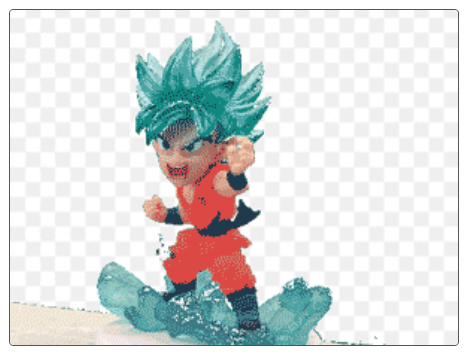

In [ ]:
from PIL import Image,ImageSequence
import cv2
import numpy as np

cap = cv2.VideoCapture('video.mov')   # 開啟影片
source = []                           # 建立 source 空串列，記錄影格內容
frame = 0                             # frame 從 0 開始

print('loading...')                   # 讀取影片
if not cap.isOpened():               
    print("Cannot open camera")
    exit()
while True:
    ret, img = cap.read()
    if not ret:
        print("Cannot receive frame")
        break
    if frame%30 == 0:                                # 每 30 格取一格
        img = cv2.resize(img, (400,300))             # 改變尺寸，加快處理效率
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)  # 修改顏色為 RGBA
        source.append(img)                           # 記錄該圖片
    frame = frame + 1                                # 改變 frame 編號
    if cv2.waitKey(1) == ord('q'): 
        break                                        # 按下 q 鍵停止
cap.release()

print('start...')                  # 開始處理每張圖片
for i in range(len(source)):       # 依序處理每張圖片
    for x in range(400):           # 依序處理每個像素
        for y in range(300):       # 依序處理每個像素
            r = source[i][y,x,0]   # 該像素的紅色數值
            g = source[i][y,x,1]   # 該像素的綠色數值
            b = source[i][y,x,2]   # 該像素的藍色數值
            if r>35 and r<100 and g>110 and g<200 and b>60 and b< 130:
                source[i][y,x,3] = 0    # 如果在顏色範圍內，將透明度設為 0

print('export single frame to gif...')  # 將每張圖片轉存為 gif
n = 0                                   # 設定檔名編號
for i in source:                        # 依序處理每張圖片
    img = Image.fromarray(i)            # 轉換成 PIL 格式
    img.save(f'temp/gif{n}.gif')        # 儲存為 gif
    n = n + 1                           # 改變儲存的檔名編號

print('loading gifs...')                # 載入所有 gif
output = []                             # 建立空串列
for i in range(n):                      # 依序處理每張 gif
    img = Image.open(f'temp/gif{i}.gif')    # 開啟該 gif
    img = img.convert("RGBA")               # 轉換為 RGBA
    output.append(img)                      # 記錄每張圖片內容

output[0].save("test2.gif", save_all=True, append_images=output[1:], duration=100, loop=0, disposal=2)   # 轉存為 gif 動畫，設定 disposal=2
print('ok...') 

cv2.destroyAllWindows()